# Fitting Methods

Here we will explore the various fitting methods in AstroPhot. You have already encountered some of the methods, but here we will take a more systematic approach and discuss their strengths/weaknesses. Each method will be applied to the same problem with the same initial conditions so you can see how they operate.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde as kde
from scipy.stats import norm

%matplotlib inline
import astrophot as ap

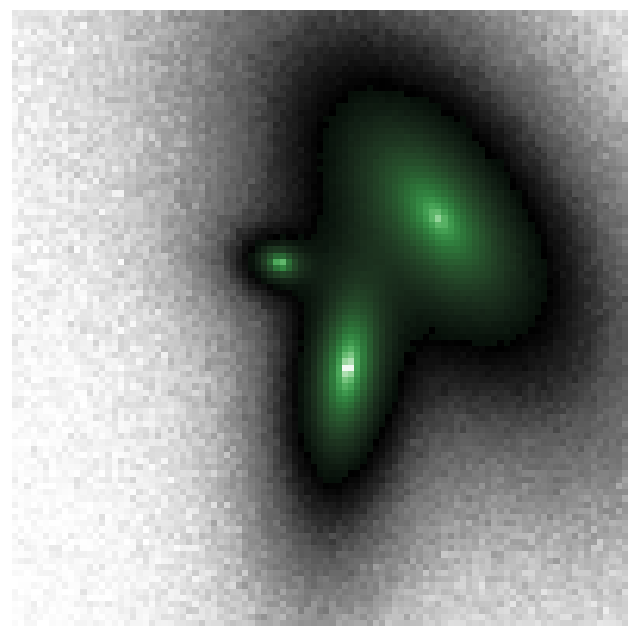

In [2]:
# Setup a fitting problem. You can ignore this cell to start, it just makes some test data to fit

def true_params():
    
    # just some random parameters to use for fitting. Feel free to play around with these to see what happens!
    sky_param = np.array([1.5])
    sersic_params = np.array([
        [ 68.44035491,  65.58516735,   0.54945988, 37.19794926*np.pi/180,   2.14513004,   22.05219055,   2.45583024],
        [ 54.00353786,  41.54430634,   0.40203928,  172.03862521*np.pi/180,   2.88613347,   12.095631,     2.76711163],
        [ 43.13601431,  58.3422508,    0.71894728, 77.07973506*np.pi/180,   3.264371,     4.3767236,     2.41520244],
    ])

    return sersic_params, sky_param

def init_params():

    sky_param = np.array([1.4])
    sersic_params = np.array([
        [ 67.,  66.,   0.6, 40.*np.pi/180,   1.5,   25.,   2.],
        [ 55.,  40.,   0.5,  170.*np.pi/180,   2.,   10.,     3.],
        [ 41.,  60.,    0.8, 80.*np.pi/180,   3.,     5.,     2.],
    ])

    return sersic_params, sky_param

def initialize_model(target, use_true_params = True):

    # Pick parameters to start the model with
    if use_true_params:
        sersic_params, sky_param = true_params()
    else:
        sersic_params, sky_param = init_params()

    # List of models, starting with the sky
    model_list = [ap.models.AstroPhot_Model(
        name = "sky",
        model_type = "flat sky model",
        target = target,
        parameters = {"F": sky_param[0]},
    )]
    # Add models to the list
    for i, params in enumerate(sersic_params):
        model_list.append([
            ap.models.AstroPhot_Model(
                name = f"sersic {i}",
                model_type = "sersic galaxy model",
                target = target,
                parameters = {
                    "center": [params[0],params[1]],
                    "q": params[2],
                    "PA": params[3],
                    "n": params[4],
                    "Re": params[5],
                    "Ie": params[6],
                },
                sampling_mode = "simpsons",
                integrate_mode = "none",
                #psf_mode = "full", # uncomment to try everything with PSF blurring (takes longer)
            )
        ])

    MODEL = ap.models.Group_Model(
        name = "group",
        models = model_list,
        target = target,
    )
    # Make sure every model is ready to go
    MODEL.initialize()
    
    return MODEL

def generate_target():

    N = 99
    pixelscale = 1.
    rng = np.random.default_rng(42)

    # PSF has sigma of 2x pixelscale
    PSF = ap.utils.initialize.gaussian_psf(2, 21, pixelscale)
    PSF /= np.sum(PSF)

    target = ap.image.Target_Image(
        data = np.zeros((N,N)),
        pixelscale = pixelscale,
        psf = PSF,
    )

    MODEL = initialize_model(target, True)
    
    # Sample the model with the true values to make a mock image
    img = MODEL().data.detach().cpu().numpy()
    # Add poisson noise
    target.data = torch.Tensor(img + rng.normal(scale = np.sqrt(img)/2))  
    target.variance = torch.Tensor(img/4)
    
    fig, ax = plt.subplots(figsize = (8,8))
    ap.plots.target_image(fig, ax, target)
    ax.axis("off")
    plt.show()

    return target


def corner_plot(chain, labels=None, bins=None, true_values=None, plot_density=True, plot_contours=True, figsize=(10, 10)):
    ndim = chain.shape[1]
    
    fig, axes = plt.subplots(ndim, ndim, figsize=figsize)
    plt.subplots_adjust(wspace=0., hspace=0.)
    if bins is None:
        bins = int(np.sqrt(chain.shape[0]))
        
    for i in range(ndim):
        for j in range(ndim):
            ax = axes[i, j]
            
            i_range = (np.min(chain[:, i]), np.max(chain[:, i]))
            j_range = (np.min(chain[:, j]), np.max(chain[:, j]))
            if i == j:
                # Plot the histogram of parameter i
                #ax.hist(chain[:, i], bins=bins, histtype="step", range = i_range, density=True, color="k", lw=1)
                
                if plot_density:
                    # Plot the kernel density estimate
                    kde_x = np.linspace(i_range[0], i_range[1], 100)
                    kde_y = kde(chain[:, i])(kde_x)
                    ax.plot(kde_x, kde_y, color="green", lw=1)
                    
                if true_values is not None:
                    ax.axvline(true_values[i], color='red', linestyle='-', lw=1)
                ax.set_xlim(i_range)

            elif i > j:
                # Plot the 2D histogram of parameters i and j
                #ax.hist2d(chain[:, j], chain[:, i], bins=bins, cmap="Greys")

                if plot_contours:
                    # Plot the kernel density estimate contours
                    kde_ij = kde([chain[:, j], chain[:, i]])
                    x, y = np.mgrid[j_range[0]:j_range[1]:100j, i_range[0]:i_range[1]:100j]
                    positions = np.vstack([x.ravel(), y.ravel()])
                    kde_pos = np.reshape(kde_ij(positions).T, x.shape)
                    ax.contour(x, y, kde_pos, colors="green", linewidths=1, levels=3)
                    
                if true_values is not None:
                    ax.axvline(true_values[j], color='red', linestyle='-', lw=1)
                    ax.axhline(true_values[i], color='red', linestyle='-', lw=1)
                ax.set_xlim(j_range)
                ax.set_ylim(i_range)

            else:
                ax.axis("off")

            if j == 0 and labels is not None:
                ax.set_ylabel(labels[i])
            ax.yaxis.set_major_locator(plt.NullLocator())

            if i == ndim - 1 and labels is not None:
                ax.set_xlabel(labels[j])
            ax.xaxis.set_major_locator(plt.NullLocator())
    
    plt.show()
    
def corner_plot_covariance(cov_matrix, mean, labels=None, figsize=(10, 10), true_values = None, ellipse_colors='g'):
    num_params = cov_matrix.shape[0]
    fig, axes = plt.subplots(num_params, num_params, figsize=figsize)
    plt.subplots_adjust(wspace=0., hspace=0.)

    for i in range(num_params):
        for j in range(num_params):
            ax = axes[i, j]

            if i == j:
                x = np.linspace(mean[i] - 3 * np.sqrt(cov_matrix[i, i]), mean[i] + 3 * np.sqrt(cov_matrix[i, i]), 100)
                y = norm.pdf(x, mean[i], np.sqrt(cov_matrix[i, i]))
                ax.plot(x, y, color='g')
                ax.set_xlim(mean[i] - 3 * np.sqrt(cov_matrix[i, i]), mean[i] + 3 * np.sqrt(cov_matrix[i, i]))
                if true_values is not None:
                    ax.axvline(true_values[i], color='red', linestyle='-', lw=1)
            elif j < i:
                cov = cov_matrix[np.ix_([j, i], [j, i])]
                lambda_, v = np.linalg.eig(cov)
                lambda_ = np.sqrt(lambda_)
                angle = np.rad2deg(np.arctan2(v[1, 0], v[0, 0]))
                for k in [1, 2]:
                    ellipse = Ellipse(xy=(mean[j], mean[i]),
                                      width=lambda_[0] * k * 2,
                                      height=lambda_[1] * k * 2,
                                      angle=angle,
                                      edgecolor=ellipse_colors,
                                      facecolor='none')
                    ax.add_artist(ellipse)

                # Set axis limits
                margin = 3
                ax.set_xlim(mean[j] - margin * np.sqrt(cov_matrix[j, j]), mean[j] + margin * np.sqrt(cov_matrix[j, j]))
                ax.set_ylim(mean[i] - margin * np.sqrt(cov_matrix[i, i]), mean[i] + margin * np.sqrt(cov_matrix[i, i]))
                
                if true_values is not None:
                    ax.axvline(true_values[j], color='red', linestyle='-', lw=1)
                    ax.axhline(true_values[i], color='red', linestyle='-', lw=1)
                
            if j > i:
                ax.axis('off')

            if i < num_params - 1:
                ax.set_xticklabels([])
            else:
                if labels is not None:
                    ax.set_xlabel(labels[j])
            ax.yaxis.set_major_locator(plt.NullLocator())

            if j > 0:
                ax.set_yticklabels([])
            else:
                if labels is not None:
                    ax.set_ylabel(labels[i])
            ax.xaxis.set_major_locator(plt.NullLocator())

    plt.show()


target = generate_target()

## Levenberg-Marquardt

This fitter is identitied as `ap.fit.LM` and it employs a variant of the second order Newton's method to converge very quickly to the local minimum. This is the generally accepted best algorithm for most use cases in $\chi^2$ minimization. If you don't know what to pick, start with this minimizer. The LM optimizer bridges the gap between first-order gradient descent and second order Newton's method. When far from the minimum, Newton's method is unstable and can give wildly wrong results, so LM takes gradient descent steps. However, near the minimum it switches to the Newton's method which has "quadratic convergence" this means that it takes only a few iterations to converge to several decimal places. This can be represented as:

$(H + LI)h = g$

Where H is the Hessian matrix of second derivatives, L is the damping parameter, I is the identity matrix, h is the step we will take in parameter space, and g is the gradient. We solve this linear system for h to get the next update step. The "L" scale parameter goes from L >> 1 which represents gradient descent to L << 1 which is Newton's Method. When L >> 1 the hessian is effectively zero and we get $h = g/L$ which is just gradient descent with $1/L$ as the learning rate. In AstroPhot the damping parameter is treated somewhat differently, but the concept is the same.

LM can handle a lot of scenarios and converge to the minimum. Keep in mind, however, that it is seeking a local minimum, so it is best to start off the algorithm as close as possible to the best fit parameters. AstroPhot can automatically initialize, as discussed in other notebooks, but even that needs help sometimes (often in the form of a segmentation map).

The main drawback of LM is its memory consumption which goes as $\mathcal{O}(PN)$ where P is the number of pixels and N is the number of parameters.

Chi^2/DoF: 279.73548622774234, L: 1.0
Chi^2/DoF: 235.01139553370626, L: 1.6666666666666667
Chi^2/DoF: 71.18471110922977, L: 0.5555555555555556
Chi^2/DoF: 28.291353177758147, L: 0.1851851851851852
Chi^2/DoF: 17.83992985625845, L: 0.308641975308642
Chi^2/DoF: 14.410956189291033, L: 0.5144032921810701
Chi^2/DoF: 6.905469726067588, L: 0.1714677640603567
Chi^2/DoF: 3.9484426972387987, L: 0.05715592135345223
Chi^2/DoF: 2.010710115059102, L: 0.019051973784484078
Chi^2/DoF: 1.2260338856852941, L: 0.006350657928161359
Chi^2/DoF: 1.012252854477365, L: 0.0021168859760537866
Chi^2/DoF: 1.01221192617795, L: 2.903821640677348e-06
Chi^2/DoF: 1.0122119260305191, L: 3.983294431656171e-09
Final Chi^2/DoF: 1.012211926030501, L: 3.983294431656171e-09. Converged: success
success


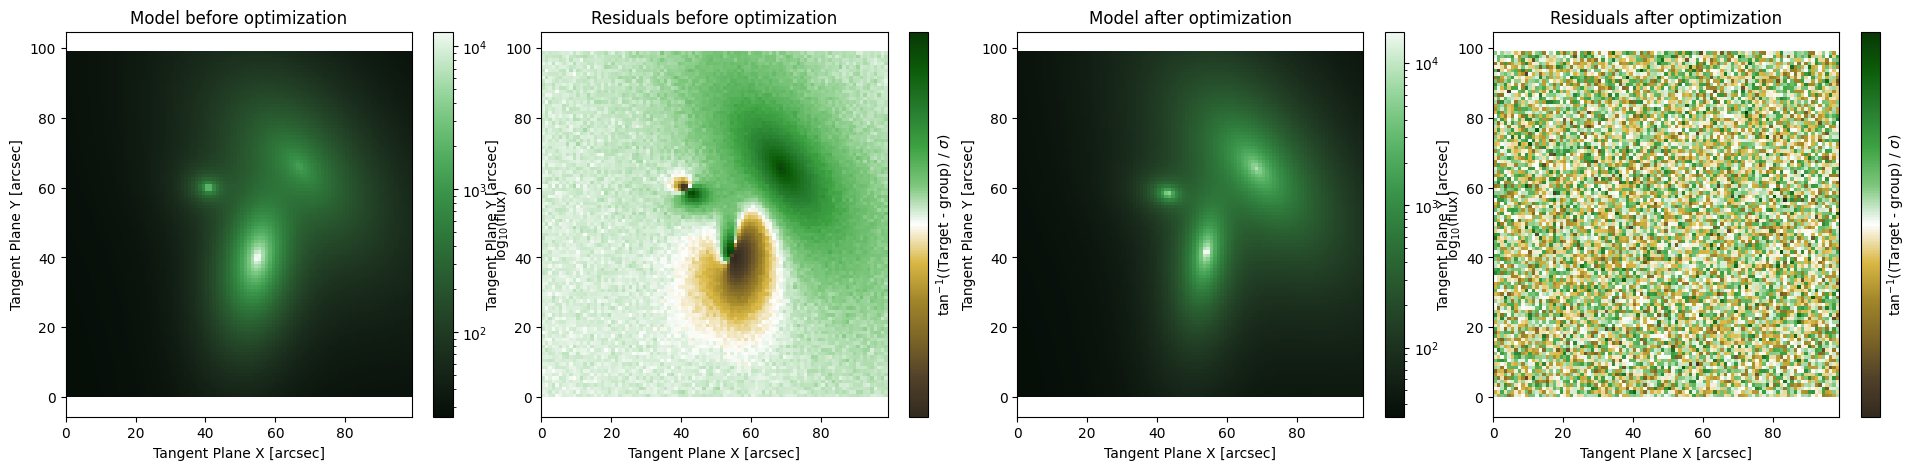

In [3]:
MODEL = initialize_model(target, False)
fig, axarr = plt.subplots(1,4, figsize = (24,5))
plt.subplots_adjust(wspace= 0.1)
ap.plots.model_image(fig, axarr[0], MODEL)
axarr[0].set_title("Model before optimization")
ap.plots.residual_image(fig, axarr[1], MODEL, normalize_residuals = True)
axarr[1].set_title("Residuals before optimization")

res_lm = ap.fit.LM(MODEL, verbose = 1).fit()
print(res_lm.message)

ap.plots.model_image(fig, axarr[2], MODEL)
axarr[2].set_title("Model after optimization")
ap.plots.residual_image(fig, axarr[3], MODEL, normalize_residuals = True)
axarr[3].set_title("Residuals after optimization")
plt.show()

Now that LM has found the $\chi^2$ minimum, we can do a really neat trick. Since LM needs the hessian matrix, we have access to the hessian matrix at the minimum. This is in fact equal to the negative Fisher information matrix. If we take the matrix inverse of this matrix then we get the covariance matrix for a multivariate gaussian approximation of the $\chi^2$ surface near the minimum. With the covariance matrix we can create a corner plot just like we would with an MCMC. We will see later that the MCMC methods (at least the ones which converge) produce very similar results! 

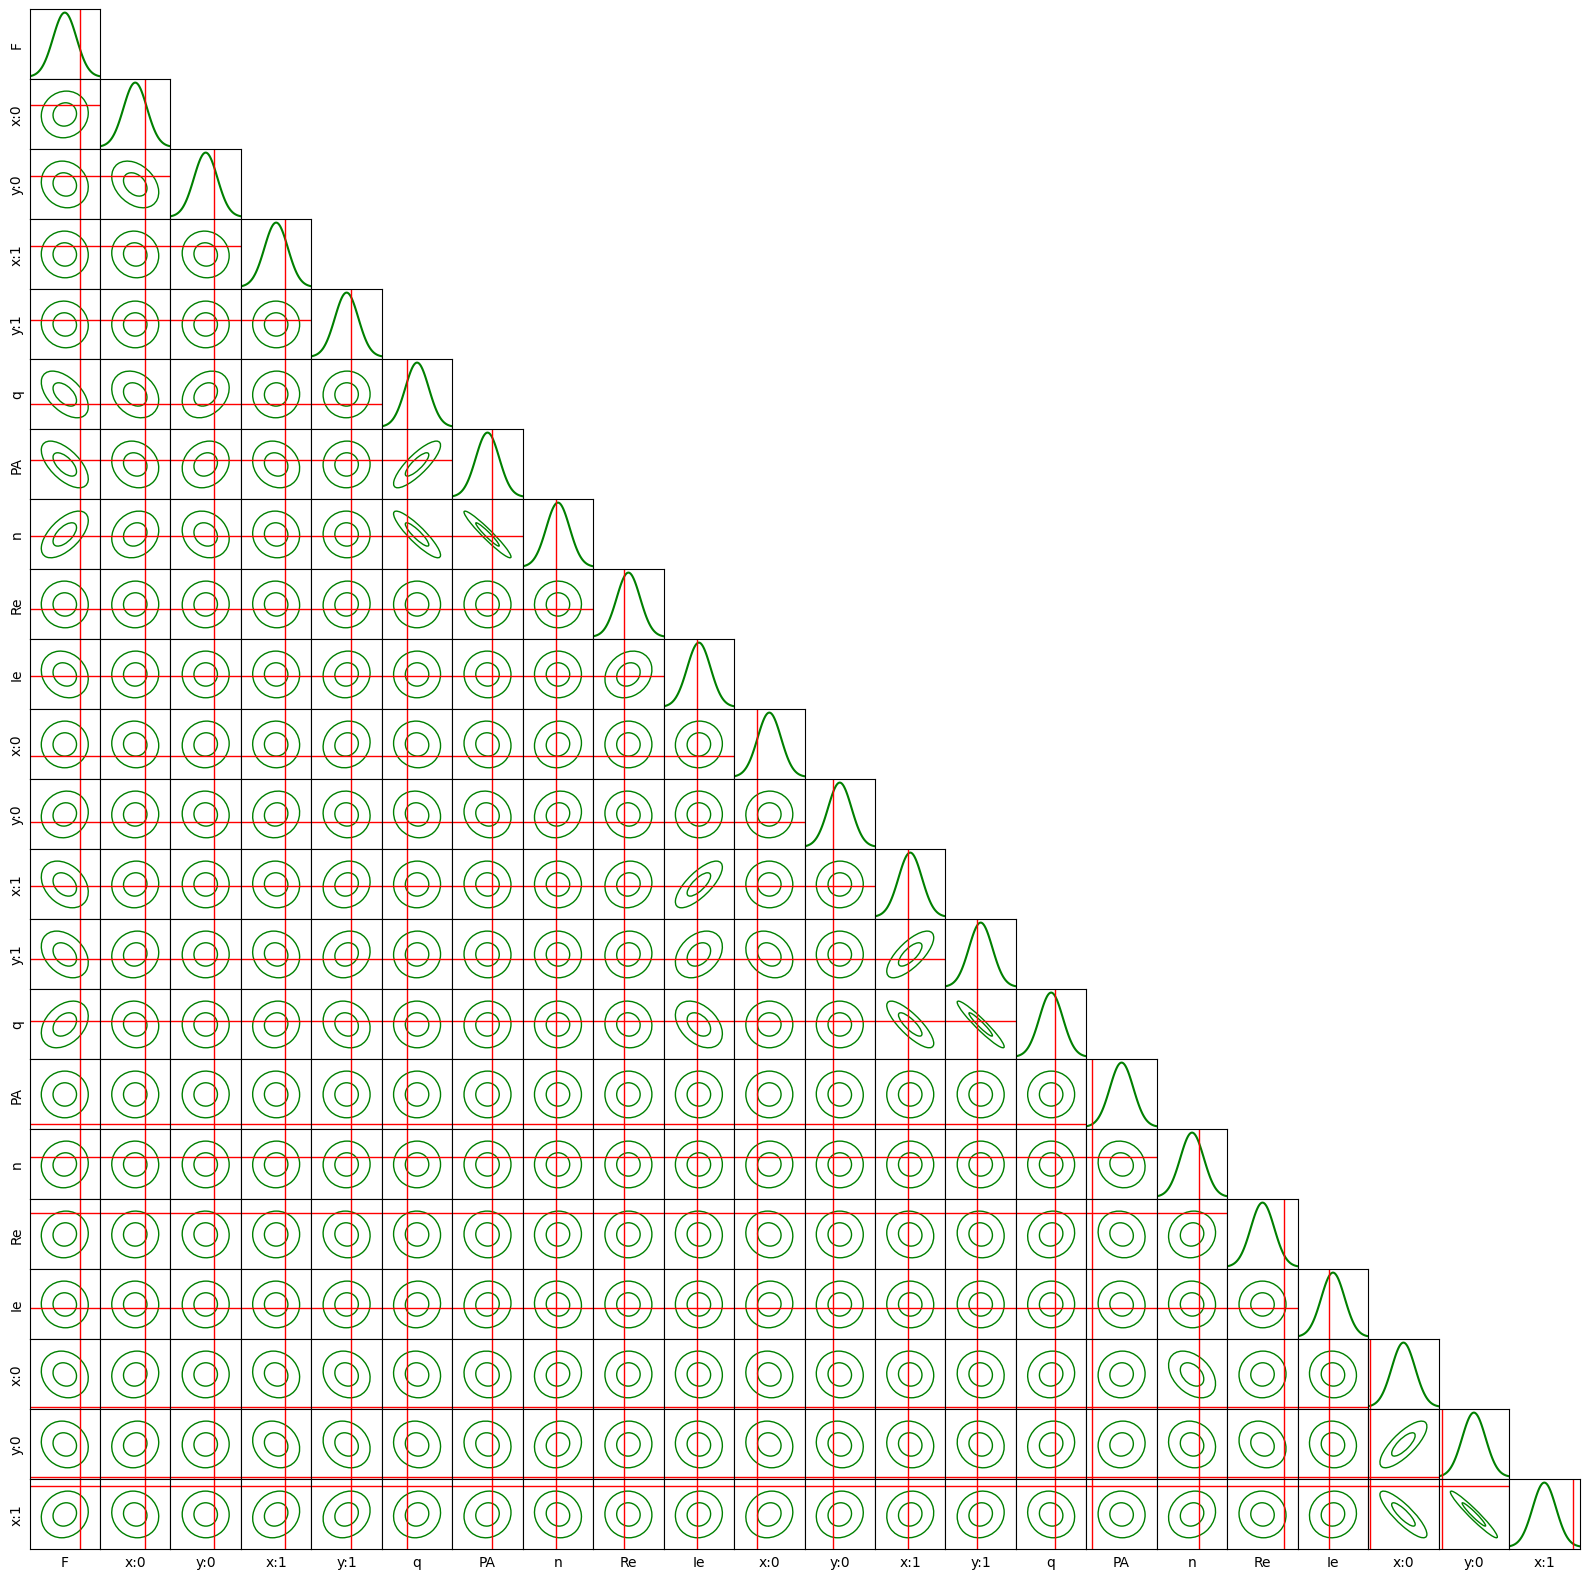

In [4]:
param_names = list(MODEL.parameters.vector_names())
i = 0
while i < len(param_names):
    param_names[i] = param_names[i].replace(" ", "")
    if "center" in param_names[i]:
        center_name = param_names.pop(i)
        param_names.insert(i, center_name.replace("center", "y"))
        param_names.insert(i, center_name.replace("center", "x"))
    i += 1
ser, sky = true_params()
corner_plot_covariance(
    res_lm.covariance_matrix.detach().cpu().numpy(), 
    MODEL.parameters.vector_values().detach().cpu().numpy(),
    labels = param_names, 
    figsize = (20,20), 
    true_values = np.concatenate((sky,ser.ravel()))
)

## Iterative Fit (models)

An iterative fitter is identified as `ap.fit.Iter`, this method is generally employed for large models where it is not feasible to hold all the relevant data in memory at once. The iterative fitter will cycle through the models in a `Group_Model` object and fit them one at a time to the image, using the residuals from the previous cycle. This can be a very robust way to deal with some fits, especially if the overlap between models is not too strong. It is however more dependent on good initialization than other methods like the Levenberg-Marquardt. Also, it is possible for the Iter method to get stuck in a local minimum under certain circumstances.

Note that while the Iterative fitter needs a `Group_Model` object to iterate over, it is not necessarily true that the sub models are `Component_Model` objects, they could be `Group_Model` objects as well. In this way it is possible to cycle through and fit "clusters" of objects that are nearby, so long as it doesn't consume too much memory.

By only fitting one model at a time it is possible to get caught in a local minimum, or to get out of a local minimum that a different fitter was stuck in. For this reason it can be good to mix-and-match the iterative optimizers so they can help each other get unstuck if a fit is very challenging. 

--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 6.146472259583412
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 2.4888285341171885
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.6343221511897523
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.2777731845495621
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.121528249957117
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.0551989243693567
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.028289560420448
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.0179020143020676
--------iter-------
sky
sersic 0
sersic 1
sersic 2
Update Chi^2 with new parameters
Loss: 1.0141034781968659
--------iter-------
sk

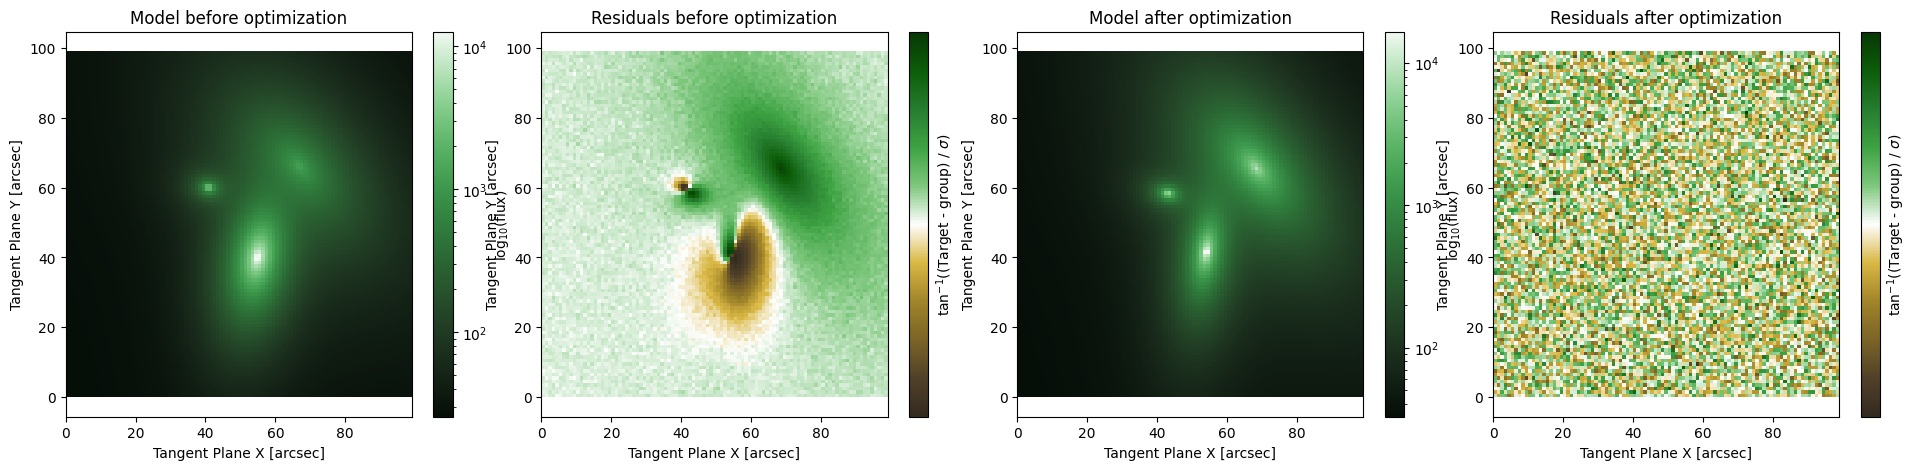

In [5]:
MODEL = initialize_model(target, False)
fig, axarr = plt.subplots(1,4, figsize = (24,5))
plt.subplots_adjust(wspace= 0.1)
ap.plots.model_image(fig, axarr[0], MODEL)
axarr[0].set_title("Model before optimization")
ap.plots.residual_image(fig, axarr[1], MODEL, normalize_residuals = True)
axarr[1].set_title("Residuals before optimization")

res_iter = ap.fit.Iter(MODEL, verbose = 1).fit()

ap.plots.model_image(fig, axarr[2], MODEL)
axarr[2].set_title("Model after optimization")
ap.plots.residual_image(fig, axarr[3], MODEL, normalize_residuals = True)
axarr[3].set_title("Residuals after optimization")
plt.show()

## Iterative Fit (parameters)

This is an iterative fitter identified as `ap.fit.Iter_LM` and is generally employed for large models where it is not feasible to hold all the relevant data in memory at once. This iterative fitter will cycle through chunks of parameters and fit them one at a time to the image. This can be a very robust way to deal with some fits, especially if the overlap between models is not too strong. This is very similar to the other iterative fitter, however it is necessary for certain fitting circumstances when the problem can't be broken down into individual component models. This occurs, for example, when the models have many shared (constrained) parameters and there is no obvious way to break down sub-groups of models (an example of this is discussed in the AstroPhot paper).

Note that this is iterating over the parameters, not the models. This allows it to handle parameter covariances even for very large models (if they happen to land in the same chunk). However, for this to work it must evaluate the whole model at each iteration making it somewhat slower than the regular `Iter` fitter, though it can make up for it by fitting larger chunks at a time which makes the whole optimization faster.

By only fitting a subset of parameters at a time it is possible to get caught in a local minimum, or to get out of a local minimum that a different fitter was stuck in. For this reason it can be good to mix-and-match the iterative optimizers so they can help each other get unstuck. Since this iterative fitter chooses parameters randomly, it can sometimes get itself unstuck if it gets a lucky combination of parameters. Generally giving it more parameters to work with at a time is better.

--------iter-------
chunk loss: 139.56390470306718
chunk loss: 27.102862602390726
Loss: 27.102862602390726
--------iter-------
chunk loss: 15.685551226049816
chunk loss: 10.815980985018289
Loss: 10.815980985018289
--------iter-------
chunk loss: 10.65829945634985
chunk loss: 8.51102858901027
Loss: 8.51102858901027
--------iter-------
chunk loss: 8.338000228629783
chunk loss: 7.754692618145464
Loss: 7.754692618145464
--------iter-------
chunk loss: 7.748200074292194
chunk loss: 7.710510078107554
Loss: 7.710510078107554
--------iter-------
chunk loss: 7.676759726096723
chunk loss: 7.643952561685396
Loss: 7.643952561685396
--------iter-------
chunk loss: 7.643742358096171
chunk loss: 7.407662005823038
Loss: 7.407662005823038
--------iter-------
chunk loss: 7.402541417689212
chunk loss: 1.418934654714242
Loss: 1.418934654714242
--------iter-------
chunk loss: 1.1500293147590746
chunk loss: 1.0934454270859522
Loss: 1.0934454270859522
--------iter-------
chunk loss: 1.0896997715503254
chunk 

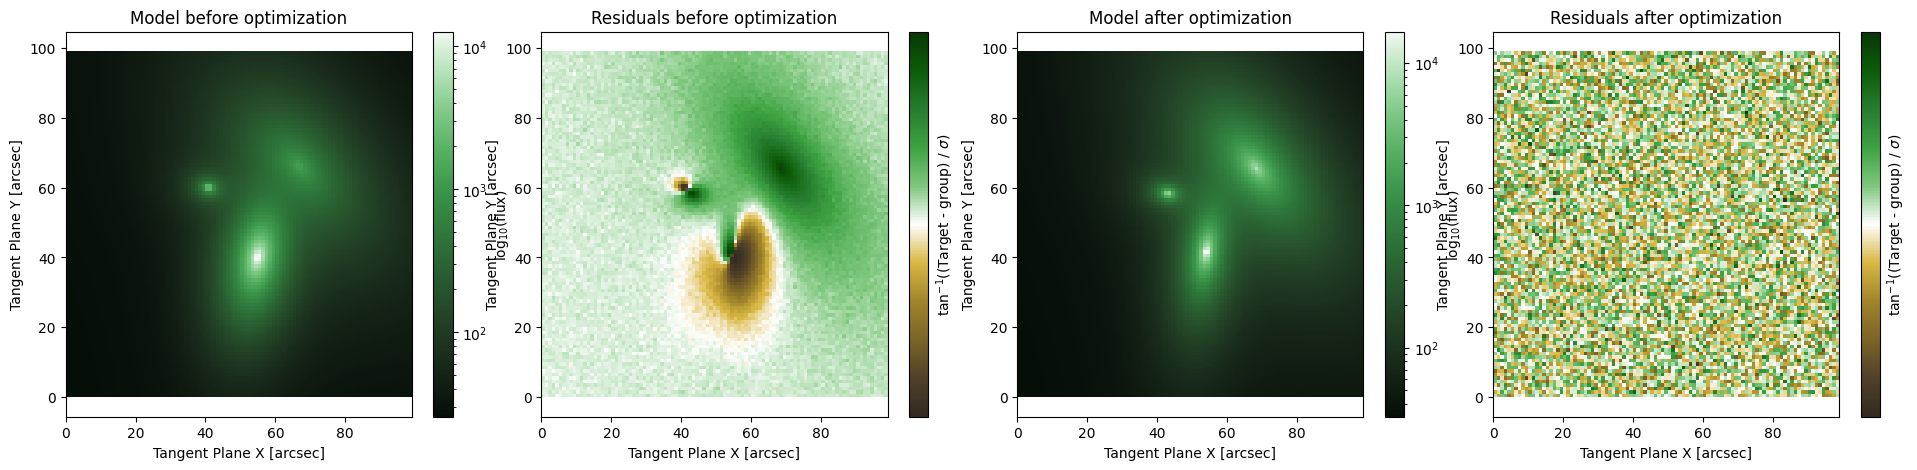

In [6]:
MODEL = initialize_model(target, False)
fig, axarr = plt.subplots(1,4, figsize = (24,5))
plt.subplots_adjust(wspace= 0.1)
ap.plots.model_image(fig, axarr[0], MODEL)
axarr[0].set_title("Model before optimization")
ap.plots.residual_image(fig, axarr[1], MODEL, normalize_residuals = True)
axarr[1].set_title("Residuals before optimization")

res_iterlm = ap.fit.Iter_LM(MODEL, chunks = 11, verbose = 1).fit()

ap.plots.model_image(fig, axarr[2], MODEL)
axarr[2].set_title("Model after optimization")
ap.plots.residual_image(fig, axarr[3], MODEL, normalize_residuals = True)
axarr[3].set_title("Residuals after optimization")
plt.show()

## Gradient Descent

A gradient descent fitter is identified as `ap.fit.Grad` and uses standard first order derivative methods as provided by PyTorch. These gradient descent methods include Adam, SGD, and LBFGS to name a few. The first order gradient is faster to evaluate and uses less memory, however it is considerably slower to converge than Levenberg-Marquardt. The gradient descent method with a small learning rate will reliably converge towards a local minimum, it will just do so slowly. 

In the example below we let it run for 1000 steps and even still it has not converged. In general you should not use gradient descent to optimize a model. However, in a challenging fitting scenario the small step size of gradient descent can actually be an advantage as it will not take any unedpectedly large steps which could mix up some models, or hop over the $\chi^2$ minimum into impossible parameter space. Just make sure to finish with LM after using Grad so that it fully converges to a reliable minimum.

iter: 100, loss: 54.90764573135732
iter: 200, loss: 31.933120122303322
iter: 300, loss: 18.26273605800143
iter: 400, loss: 11.273260348790027
iter: 500, loss: 7.075738669090284
iter: 600, loss: 4.098082863940165
iter: 700, loss: 2.1337245303704337
iter: 800, loss: 1.8231178560799315
iter: 900, loss: 1.6832737415431092
iter: 1000, loss: 1.6115471185095493


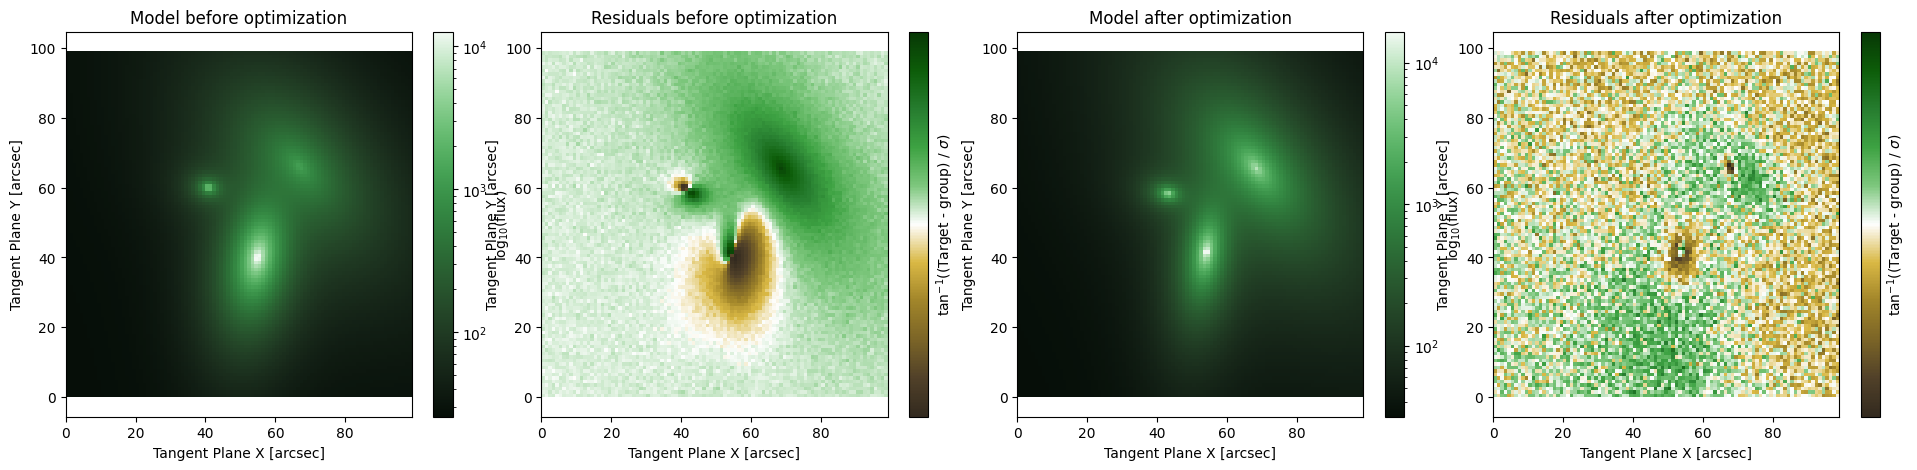

In [7]:
MODEL = initialize_model(target, False)
fig, axarr = plt.subplots(1,4, figsize = (24,5))
plt.subplots_adjust(wspace= 0.1)
ap.plots.model_image(fig, axarr[0], MODEL)
axarr[0].set_title("Model before optimization")
ap.plots.residual_image(fig, axarr[1], MODEL, normalize_residuals = True)
axarr[1].set_title("Residuals before optimization")

res_grad = ap.fit.Grad(MODEL, verbose = 1, max_iter = 1000, optim_kwargs = {"lr": 5e-3}).fit()

ap.plots.model_image(fig, axarr[2], MODEL)
axarr[2].set_title("Model after optimization")
ap.plots.residual_image(fig, axarr[3], MODEL, normalize_residuals = True)
axarr[3].set_title("Residuals after optimization")
plt.show()

## No U-Turn Sampler (NUTS)

Unlike the above methods, `ap.fit.NUTS` does not stricktly seek a minimum $\chi^2$, instead it is an MCMC method which seeks to explore the likelihood space and provide a full posterior in the form of random samples. The NUTS method in AstroPhot is actually just a wrapper for the Pyro implementation (__[link here](https://docs.pyro.ai/en/stable/index.html)__). Most of the functionality can be accessed this way, though for very advanced applications it may be necessary to manually interface with Pyro (this is not very challenging as AstroPhot is fully differentiable).

The first iteration of NUTS is always very slow since it compiles the forward method on the fly, after that each sample is drawn much faster. The warmup iterations take longer as the method is exploring the space and determining the ideal step size and mass matrix for fast integration with minimal numerical error (we only do 20 warmup steps here, if something goes wrong just try rerunning). Once the algorithm begins sampling it is able to move quickly (for an MCMC) throught the parameter space. For many models, the NUTS sampler is able to collect nearly completely uncorrelated samples, meaning that even 100 is enough to get a good estimate of the posterior.

NUTS is far faster than other MCMC implementations such as a standard Metropolis Hastings MCMC. However, it is still a lot slower than the other optimizers (LM) since it is doing more than seeking a single high likelihood point, it is fully exploring the likelihood space. In simple cases, the automatic covariance matrix from LM is likely good enough, but if one really needs access to the full posterior of a complex model then NUTS is the best way to get it.

For an excellent introduction to the Hamiltonian Monte-Carlo and a high level explanation of NUTS see this review:
__[Betancourt 2018](https://arxiv.org/pdf/1701.02434.pdf)__

In [8]:
MODEL = initialize_model(target, False)

# Use LM to start the sampler at a high likelihood location, no burn-in needed!
# In general, NUTS is quite fast to do burn-in so this is often not needed
res1 = ap.fit.LM(MODEL).fit()

# Run the NUTS sampler
res_nuts = ap.fit.NUTS(
    MODEL, 
    warmup = 20, 
    max_iter = 100, 
    inv_mass = res1.covariance_matrix,
).fit()

Warmup:   0%|                                             | 0/120 [00:00, ?it/s]

RuntimeError: NYI: Named tensors are not supported with the tracer
Trace Shapes:             
 Param Sites:             
Sample Sites:             
       x dist         22 |
        value tensor(22) |

Note that there is no "after optimization" image above, because optimization was not done, it was full likelihood exploration. We can now create a corner plot with 2D projections of the 22 dimensional space that NUTS was exploring. The resulting corner plot is about what you would expect to get with 100 samples drawn from the multivariate gaussian found by LM above. If you run it again with more samples then the results will get even smoother.

In [ ]:
# corner plot of the posterior
# observe that it is very similar to the corner plot from the LM optimization since this case can be roughly
# approximated as a multivariate gaussian centered on the maximum likelihood point
param_names = list(MODEL.parameters.vector_names())
i = 0
while i < len(param_names):
    param_names[i] = param_names[i].replace(" ", "")
    if "center" in param_names[i]:
        center_name = param_names.pop(i)
        param_names.insert(i, center_name.replace("center", "y"))
        param_names.insert(i, center_name.replace("center", "x"))
    i += 1
    
ser, sky = true_params()
corner_plot(
    res_nuts.chain.detach().cpu().numpy(), 
    labels = param_names, 
    figsize = (20,20), 
    true_values = np.concatenate((sky,ser.ravel()))
)

## Hamiltonian Monte-Carlo (HMC)

The `ap.fit.HMC` is a simpler variant of the NUTS sampler. HMC takes a fixed number of steps at a fixed step size following Hamiltonian dynamics. This is in contrast to NUTS which attempts to optimally choose these parameters. HMC may be suitable in some cases where NUTS is unable to find ideal parameters. Also in some cases where you already know the pretty good step parameters HMC may run faster. If you don't want to fiddle around with parameters then stick with NUTS, HMC results will still have autocorrelation which will depend on the problem and choice of step parameters.

In [ ]:
MODEL = initialize_model(target, False)

# Use LM to start the sampler at a high likelihood location, no burn-in needed!
res1 = ap.fit.LM(MODEL).fit()

# Run the HMC sampler
res_hmc = ap.fit.HMC(
    MODEL, 
    warmup = 20, 
    max_iter = 200, 
    epsilon = 1e-1, 
    leapfrog_steps = 20, 
    inv_mass = res1.covariance_matrix,
).fit()

In [ ]:
# corner plot of the posterior
param_names = list(MODEL.parameters.vector_names())
i = 0
while i < len(param_names):
    param_names[i] = param_names[i].replace(" ", "")
    if "center" in param_names[i]:
        center_name = param_names.pop(i)
        param_names.insert(i, center_name.replace("center", "y"))
        param_names.insert(i, center_name.replace("center", "x"))
    i += 1
    
ser, sky = true_params()
corner_plot(
    res_hmc.chain.detach().cpu().numpy(), 
    labels = param_names, 
    figsize = (20,20), 
    true_values = np.concatenate((sky,ser.ravel()))
)

## Metropolis Hastings

This is the classic MCMC algorithm using the Metropolis Hastngs accept step identified with `ap.fit.MHMCMC`. One can set the gaussian random step scale and then explore the posterior. While this technically always works, in practice it can take exceedingly long to actually converge to the posterior. This is because the step size must be set very small to have a reasonable likelihood of accepting each step, so it never moves very far in parameter space. With each subsequent sample being very close to the previous sample it can take a long time for it to wander away from its starting point. In the example below it would take an extremely long time for the chain to converge. Instead of waiting that long, we demonstrate the functionality with 5000 steps, but suggest using NUTS for any real world problem. Still, if there is something NUTS can't handle (a function that isn't differentiable) then MHMCMC can save the day (even if it takes all day to do it).

In [ ]:
MODEL = initialize_model(target, False)
fig, axarr = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace= 0.1)
ap.plots.model_image(fig, axarr[0], MODEL)
axarr[0].set_title("Model before optimization")
ap.plots.residual_image(fig, axarr[1], MODEL, normalize_residuals = True)
axarr[1].set_title("Residuals before optimization")
plt.show()

# Use LM to start the sampler at a high likelihood location, no burn-in needed!
res1 = ap.fit.LM(MODEL).fit()

# Run the HMC sampler
res_mh = ap.fit.MHMCMC(MODEL, verbose = 1, max_iter = 5000, epsilon = 1e-4, report_after = np.inf).fit()

In [ ]:
# corner plot of the posterior
# note that, even 5000 samples is not enough to overcome the autocorrelation so the posterior has not converged.
# In fact it is not even close to convergence as can be seen by the multi-modal blobs in the posterior since this 
# problem is unimodal (except the modes where models are swapped). It is almost never worthwhile to use this 
# sampler except as a sanity check on very simple models.
param_names = list(MODEL.parameters.vector_names())
i = 0
while i < len(param_names):
    param_names[i] = param_names[i].replace(" ", "")
    if "center" in param_names[i]:
        center_name = param_names.pop(i)
        param_names.insert(i, center_name.replace("center", "y"))
        param_names.insert(i, center_name.replace("center", "x"))
    i += 1
    
ser, sky = true_params()
corner_plot(
    res_mh.chain[::10], # thin by a factor 10 so the plot works in reasonable time
    labels = param_names, 
    figsize = (20,20), 
    true_values = np.concatenate((sky,ser.ravel()))
)